Compare synthetic spectra generated based on GAMA to actual spectra from the GAMA DR3

In [19]:
import numpy as np 
import urllib
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM
# -- 
from redrock.external import desi

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

read in gama `SpecAll.fits` files, which contains all the references for fits file urls and such

In [3]:
fspecall = fits.open(''.join([UT.dat_dir(), 'gama/SpecAll.fits']))
fspecall.verify('fix')
specall = fspecall[1].data

 [astropy.io.fits.verify]


In [76]:
def getSpecURL(survey, cataid): 
    '''given survey and specid get the url of the spectra file
    '''
    isspec = (specall['survey'].lower() == survey.strip().lower()) & (specall['cataid'] == cataid)
    if np.sum(isspec) == 0: 
        raise ValueError('no match')
    elif np.sum(isspec) > 1: 
        if specall['z'][isspec].min() == specall['z'][isspec].max(): 
            print specall['url'][isspec], specall['z'][isspec]
            return specall['url'][isspec][0]
        #raise ValueError('more than one match')
    else: 
        return specall['url'][isspec][0]

In [6]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [7]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [8]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

In [9]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


In [10]:
f_spec_dark = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

In [11]:
def GAMA_subsample(index, colour='C0', size=None): 
    ''' highlight the subsample in the color-magnitude and color-Halpha 
    relations of the entire GAMA sample
    '''
    if size is None: ss = 1.
    else: ss=size
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=ss)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=ss)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=ss)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None

In [12]:
gama_spec_survey = np.array([surv.strip() for surv in gleg['gama-spec']['survey']])

Lets first compare the spectra of GAMA objects with spectra from SDSS

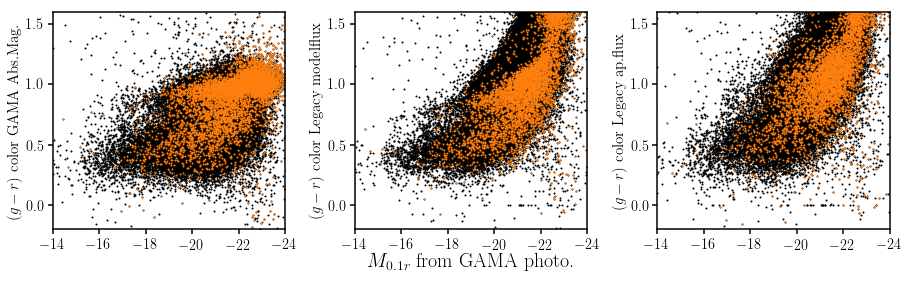

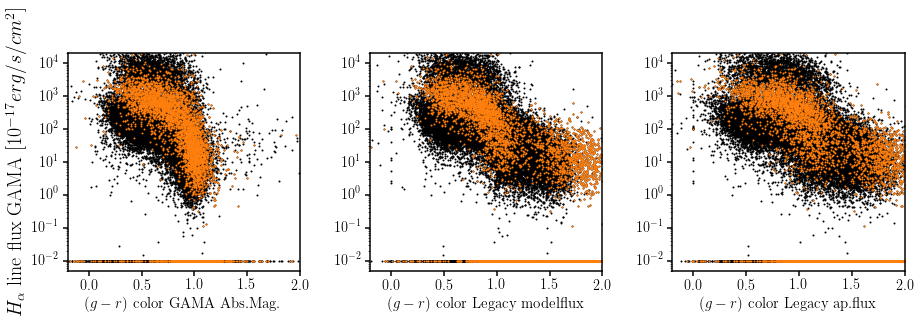

In [13]:
GAMA_subsample(np.arange(ngal)[gama_spec_survey == 'SDSS'], colour='C1')

In this particular block, we have ~100 galaxies with SDSS spectra

In [58]:
is_sdss = (gama_spec_survey[i_dark] == 'SDSS') 
print('%i sdss spectra' % np.sum(is_sdss))

103 sdss spectra


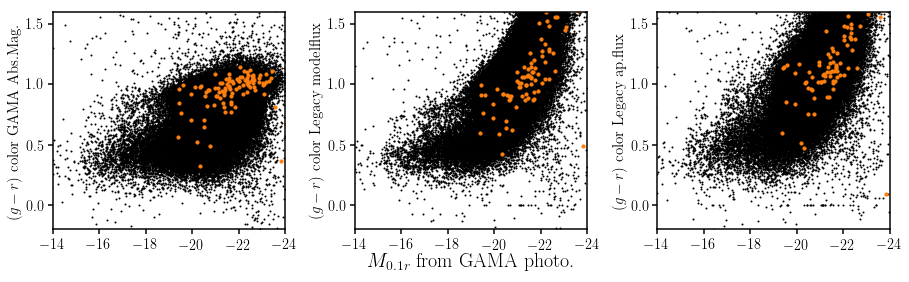

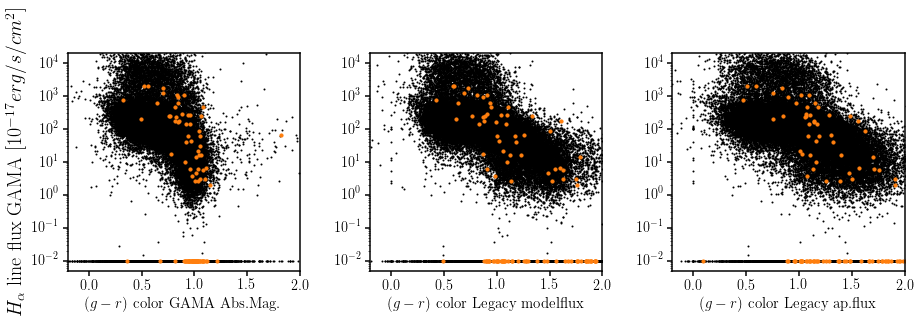

In [59]:
GAMA_subsample(i_dark[is_sdss], colour='C1', size=10)

Focusing on the SDSS spectra with high H$\alpha$

In [60]:
is_sdss_highha = ((gama_spec_survey[i_dark] == 'SDSS') & (gama_ha[i_dark] > 10**2.5))
print('%i sdss spectra' % np.sum(is_sdss_highha))

12 sdss spectra


In [34]:
fspec_is_sdss_highha = []
for ii in i_dark[is_sdss_highha]: 
    url = getSpecURL('sdss', gleg['gama-spec']['cataid'][ii])
    flocal = ''.join([UT.dat_dir(), 'gama/spectra/', url.split('/')[-1].strip()])
    fspec_is_sdss_highha.append(flocal)
    urllib.urlretrieve(url, flocal)

['http://www.gama-survey.org/dr2/data/spectra/sdss/spSpec-52404-0918-376.fit'
 'http://www.gama-survey.org/dr2/data/spectra/sdss/spSpec-51613-0305-181.fit'] [0.05557 0.05557]


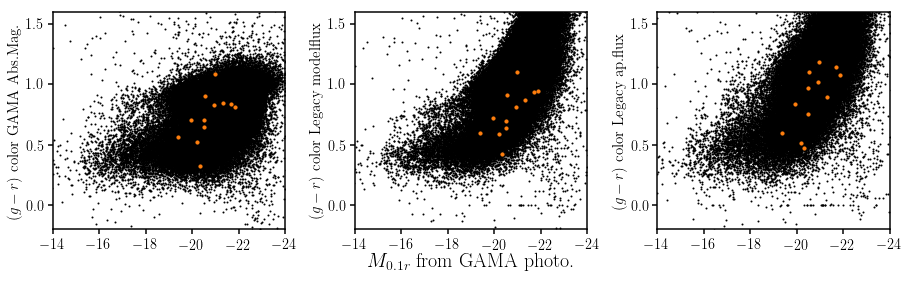

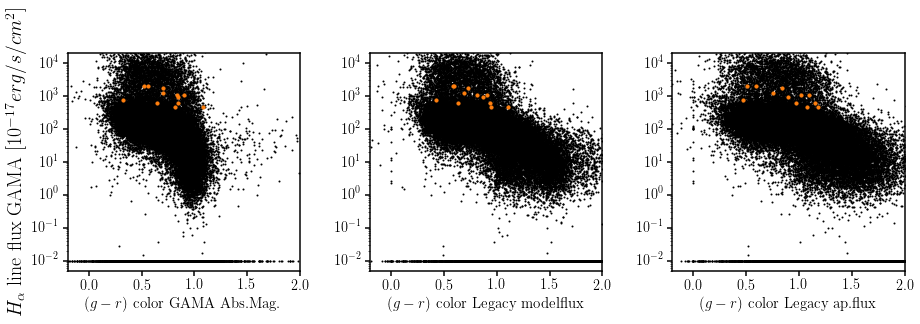

In [33]:
GAMA_subsample(i_dark[is_sdss_highha], colour='C1', size=10)

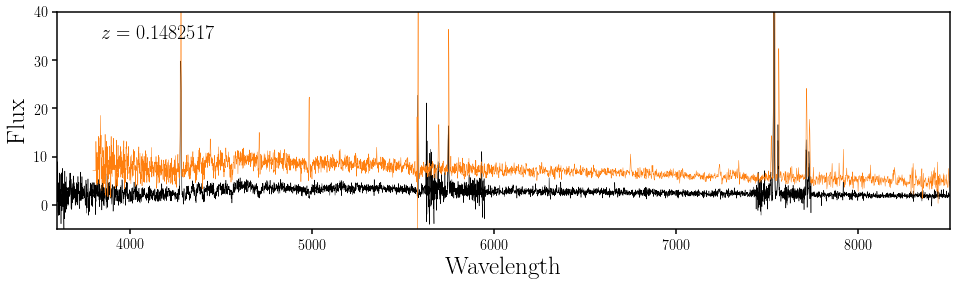

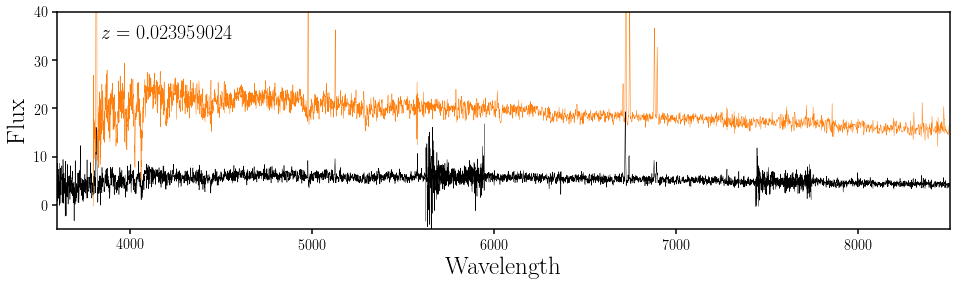

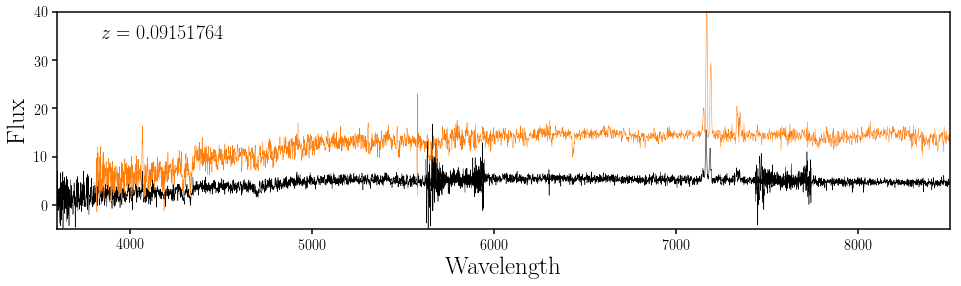

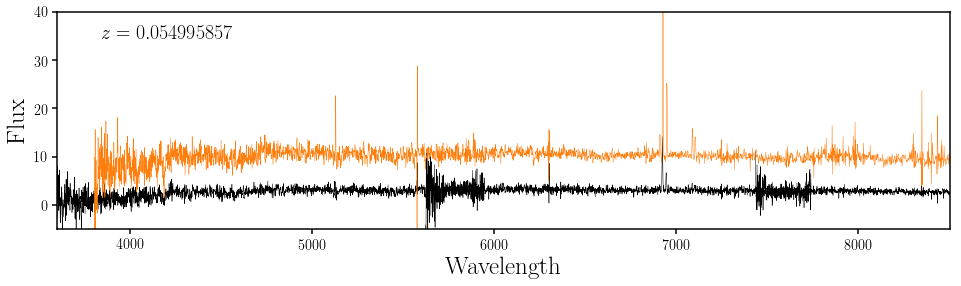

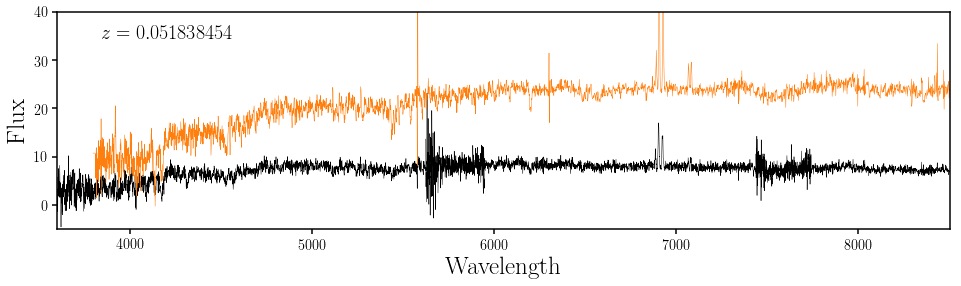

In [57]:
for i in range(5): 
    i_targ = np.arange(len(i_dark))[is_sdss_highha][i]
    fig = plt.figure(figsize=(16,4))
    sub = fig.add_subplot(1,1,1)
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        sub.plot(s_dark.wave, s_dark.flux, c='k', lw=0.5, label='Syn. Spectra') #s=0.5)
    f_sdss_spec = fits.open(fspec_is_sdss_highha[i])
    flux_sdss = f_sdss_spec[0].data[0,:]
    wave_sdss = np.logspace(f_sdss_spec[0].header['COEFF0'],
                            f_sdss_spec[0].header['COEFF0']+f_sdss_spec[0].header['COEFF1']*f_sdss_spec[0].data.shape[1],
                            f_sdss_spec[0].data.shape[1])
    sub.plot(wave_sdss, flux_sdss, c='C1', lw=0.5)

    sub.text(0.05, 0.95, '$z='+str(redshift[i_dark][i_targ])+'$',
             ha='left', va='top', transform=sub.transAxes, fontsize=20)  

    sub.set_xlabel('Wavelength', fontsize=25)
    sub.set_xlim([3600., 8500.])
    sub.set_ylabel('Flux', fontsize=25)
    sub.set_ylim([-5., 40])

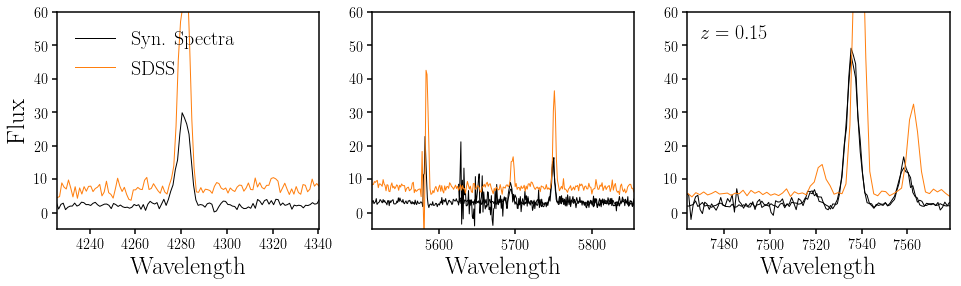

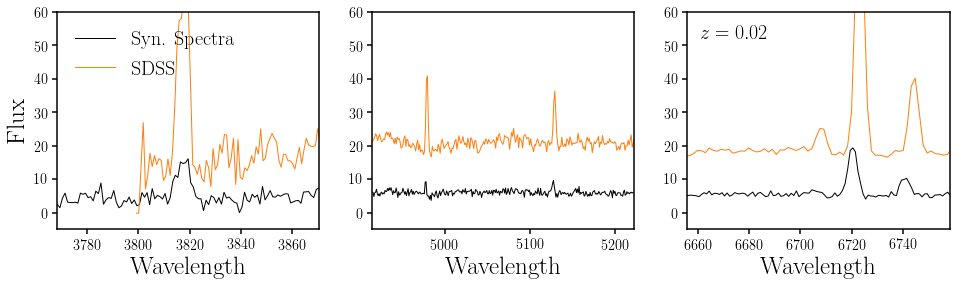

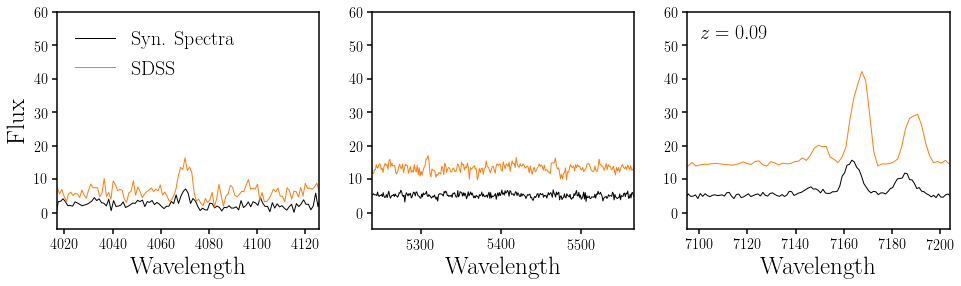

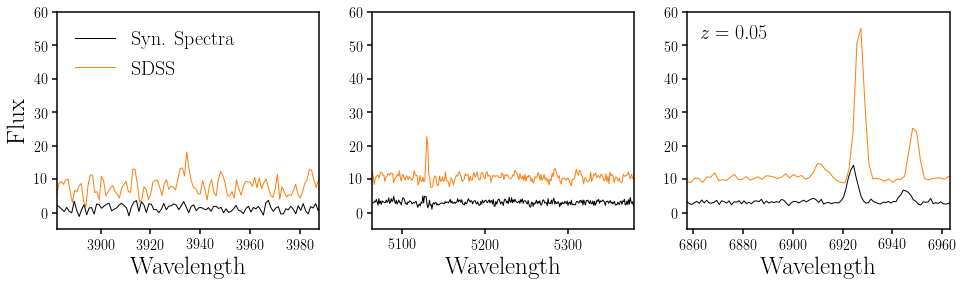

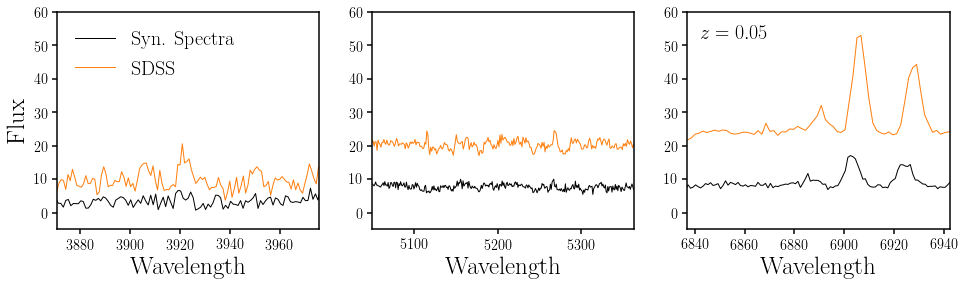

In [56]:
for i in range(5): 
    i_targ = np.arange(len(i_dark))[is_sdss_highha][i]
    z_targ = redshift[i_dark][i_targ]
    fig = plt.figure(figsize=(16,4))
    xranges = [[3680., 3780.], [4800., 5100.], [6500., 6600.]]
    for ii in range(3): 
        sub = fig.add_subplot(1,3,1+ii)
        lbl = 'Syn. Spectra'
        for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
            sub.plot(s_dark.wave, s_dark.flux, c='k', lw=1, label=lbl)
            lbl = None
        f_sdss_spec = fits.open(fspec_is_sdss_highha[i])
        flux_sdss = f_sdss_spec[0].data[0,:]
        wave_sdss = np.logspace(f_sdss_spec[0].header['COEFF0'],
                                f_sdss_spec[0].header['COEFF0']+f_sdss_spec[0].header['COEFF1']*f_sdss_spec[0].data.shape[1],
                                f_sdss_spec[0].data.shape[1])
        sub.plot(wave_sdss, flux_sdss, c='C1', lw=1, label='SDSS')
        
        if ii == 0: 
            sub.set_ylabel('Flux', fontsize=25)
            sub.legend(loc='upper left', prop={'size': 20})
        elif ii == 2: 
            sub.text(0.05, 0.95, '$z='+str(round(z_targ,2))+'$',
                     ha='left', va='top', transform=sub.transAxes, fontsize=20)  
        sub.set_xlabel('Wavelength', fontsize=25)
        sub.set_xlim((1.+z_targ)*np.array(xranges[ii]))
        sub.set_ylim([-5., 60])

Now lets compare our synthetic spectra to GAMA spectra from GAMA (the majority of the spectra)

799 GAMA spectra


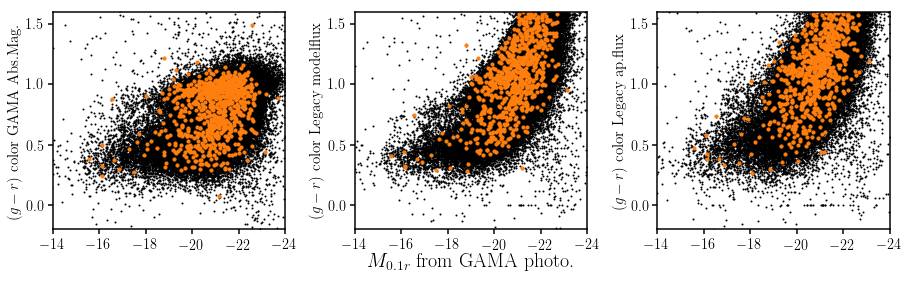

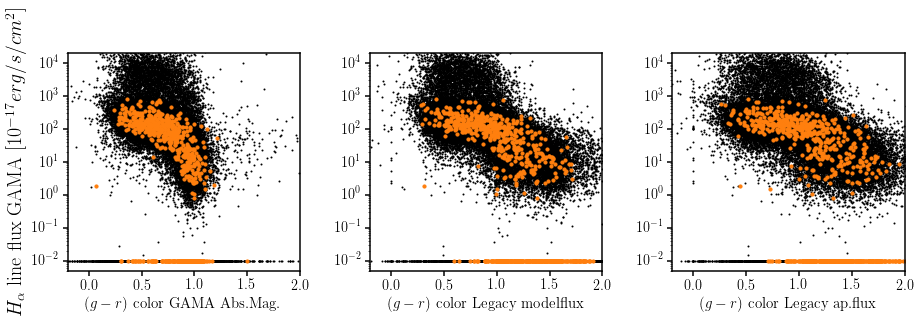

In [101]:
is_gama = (gama_spec_survey[i_dark] == 'GAMA') 
print('%i GAMA spectra' % np.sum(is_gama))
GAMA_subsample(i_dark[is_gama], colour='C1', size=10)

again we look at GAMA spectra with high H$\alpha$

30 sdss spectra


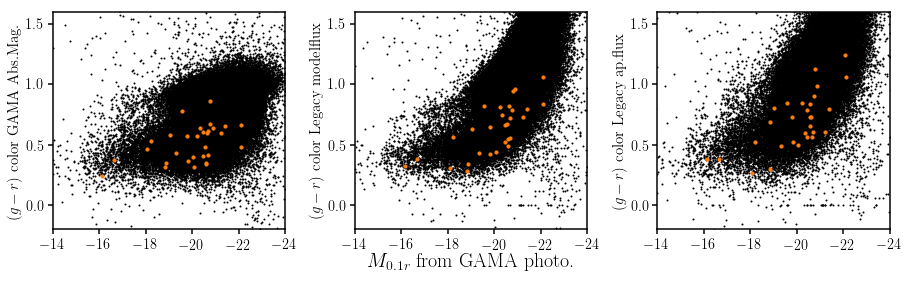

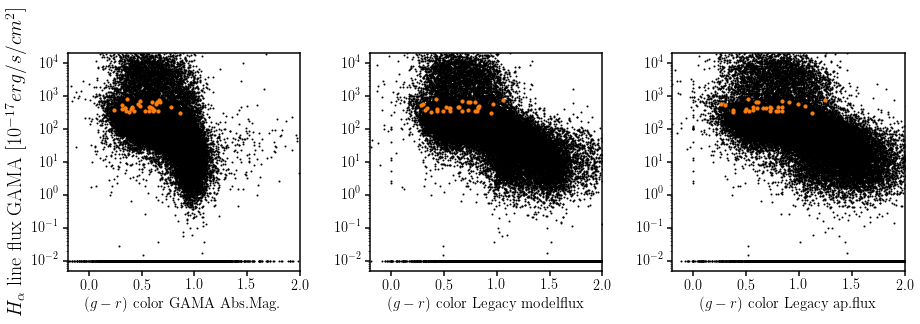

In [86]:
is_gama_highha = ((gama_spec_survey[i_dark] == 'GAMA') & (gama_ha[i_dark] > 10**2.5))
print('%i sdss spectra' % np.sum(is_gama_highha))
GAMA_subsample(i_dark[is_gama_highha], colour='C1', size=10)

In [88]:
fspec_is_gama_highha = []
for ii in i_dark[is_gama_highha]: 
    try: 
        url = getSpecURL('gama', gleg['gama-spec']['cataid'][ii])
    except ValueError: 
        is_gama_highha[i_dark == ii] = False
        continue 
    flocal = ''.join([UT.dat_dir(), 'gama/spectra/', url.split('/')[-1].strip()])
    fspec_is_gama_highha.append(flocal)
    urllib.urlretrieve(url, flocal)

some of the GAMA objects can't seem to find matches... I should look into this

In [91]:
np.sum(is_gama_highha)

21

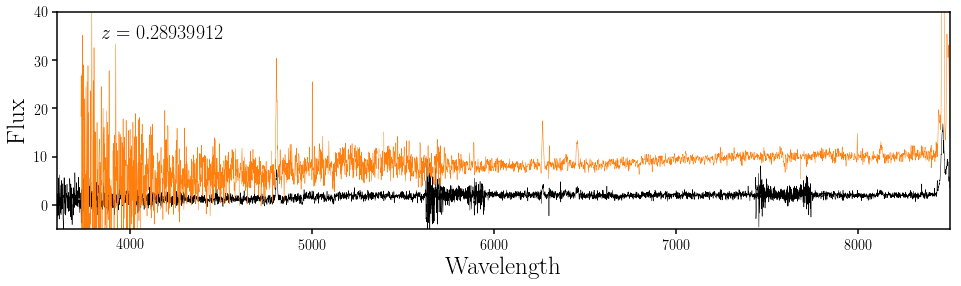

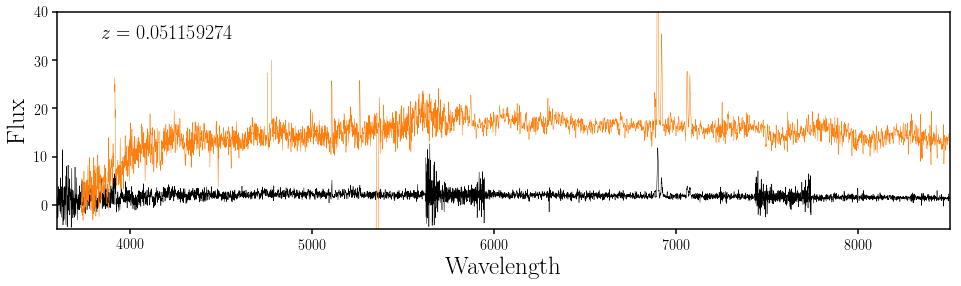

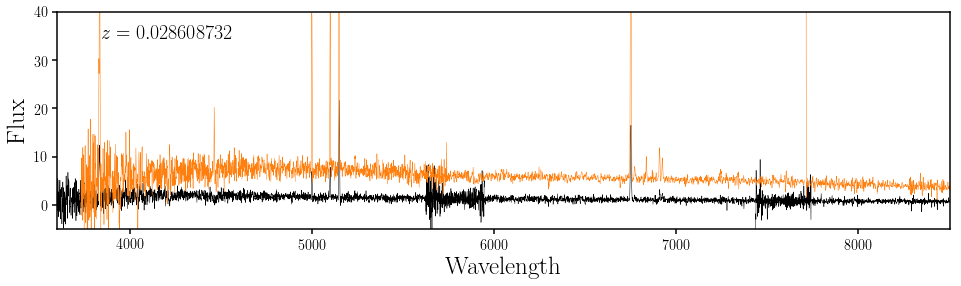

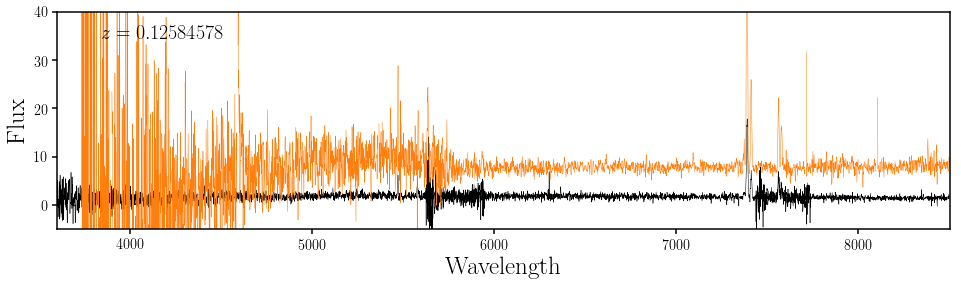

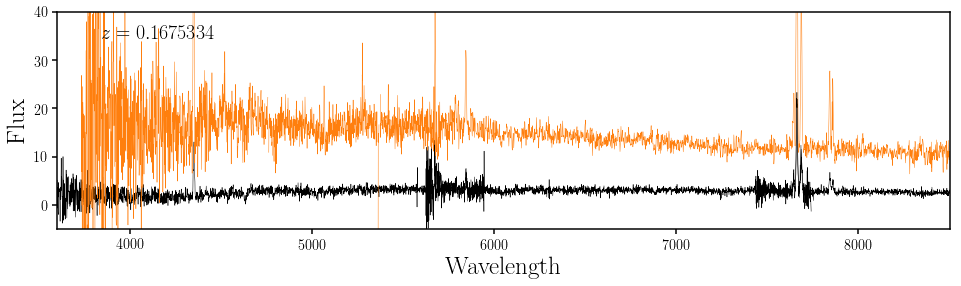

In [97]:
for i in range(5): 
    i_targ = np.arange(len(i_dark))[is_gama_highha][i]
    fig = plt.figure(figsize=(16,4))
    sub = fig.add_subplot(1,1,1)
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        sub.plot(s_dark.wave, s_dark.flux, c='k', lw=0.5, label='Syn. Spectra') #s=0.5)
    f_sdss_spec = fits.open(fspec_is_gama_highha[i])
    flux_sdss = f_sdss_spec[0].data[0,:]
    wave_sdss = np.linspace(f_sdss_spec[0].header['WMIN'], f_sdss_spec[0].header['WMAX'], len(flux_sdss))
    #np.logspace(f_sdss_spec[0].header['COEFF0'],                           f_sdss_spec[0].header['COEFF0']+f_sdss_spec[0].header['COEFF1']*f_sdss_spec[0].data.shape[1],f_sdss_spec[0].data.shape[1])
    sub.plot(wave_sdss, flux_sdss, c='C1', lw=0.5)

    sub.text(0.05, 0.95, '$z='+str(redshift[i_dark][i_targ])+'$',
             ha='left', va='top', transform=sub.transAxes, fontsize=20)  

    sub.set_xlabel('Wavelength', fontsize=25)
    sub.set_xlim([3600., 8500.])
    sub.set_ylabel('Flux', fontsize=25)
    sub.set_ylim([-5., 40])

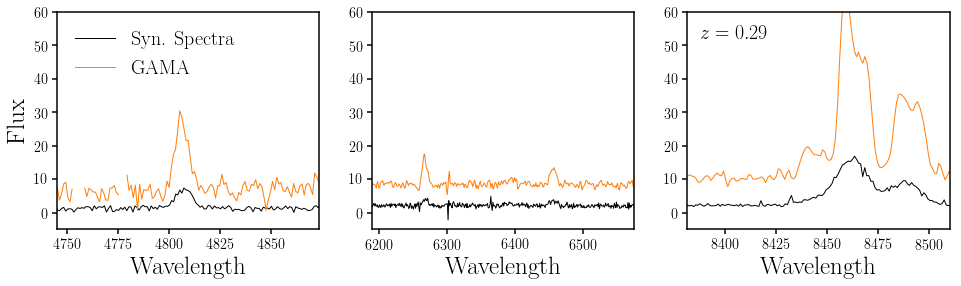

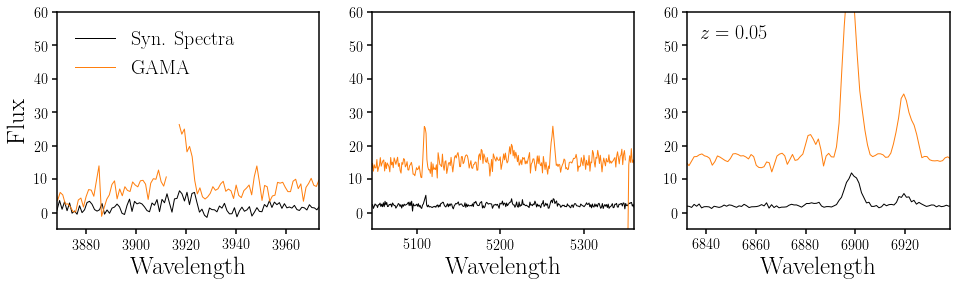

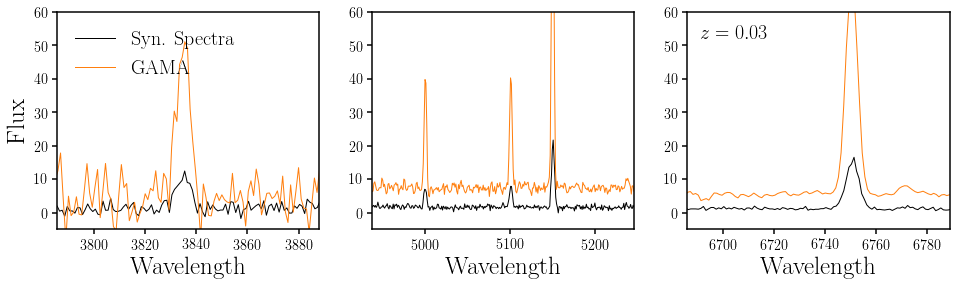

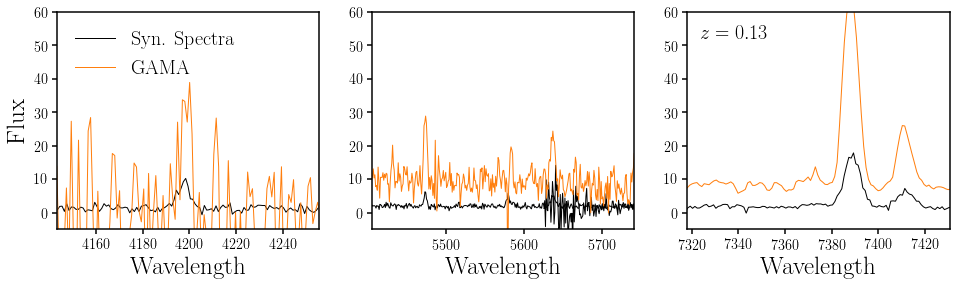

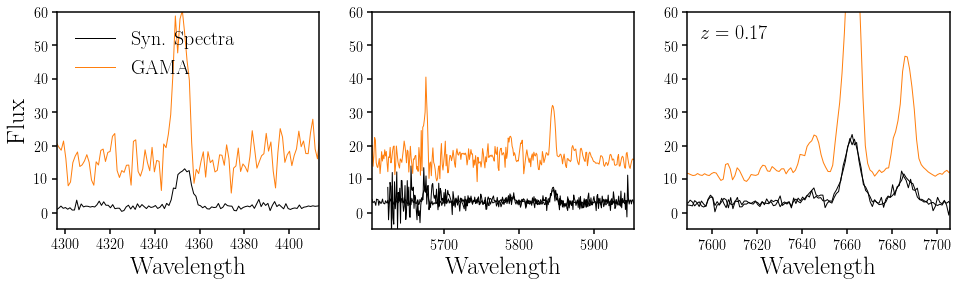

In [102]:
for i in range(5): 
    i_targ = np.arange(len(i_dark))[is_gama_highha][i]
    z_targ = redshift[i_dark][i_targ]
    fig = plt.figure(figsize=(16,4))
    xranges = [[3680., 3780.], [4800., 5100.], [6500., 6600.]]
    for ii in range(3): 
        sub = fig.add_subplot(1,3,1+ii)
        lbl = 'Syn. Spectra'
        for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
            sub.plot(s_dark.wave, s_dark.flux, c='k', lw=1, label=lbl)
            lbl = None
        f_sdss_spec = fits.open(fspec_is_gama_highha[i])
        flux_sdss = f_sdss_spec[0].data[0,:]
        wave_sdss = np.linspace(f_sdss_spec[0].header['WMIN'], f_sdss_spec[0].header['WMAX'], len(flux_sdss))
        sub.plot(wave_sdss, flux_sdss, c='C1', lw=1, label='GAMA')
        
        if ii == 0: 
            sub.set_ylabel('Flux', fontsize=25)
            sub.legend(loc='upper left', prop={'size': 20})
        elif ii == 2: 
            sub.text(0.05, 0.95, '$z='+str(round(z_targ,2))+'$',
                     ha='left', va='top', transform=sub.transAxes, fontsize=20)  
        sub.set_xlabel('Wavelength', fontsize=25)
        sub.set_xlim((1.+z_targ)*np.array(xranges[ii]))
        sub.set_ylim([-5., 60])